Submitted by: Roshan Rayala Bhaskar, Sharath Kumar
Tutorial referred: https://github.com/developershutt/Autoencoders/tree/main/4%20-%20Variational%20Autoencoder

In [85]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [86]:
import cv2

In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [88]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [89]:
#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Reshape
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

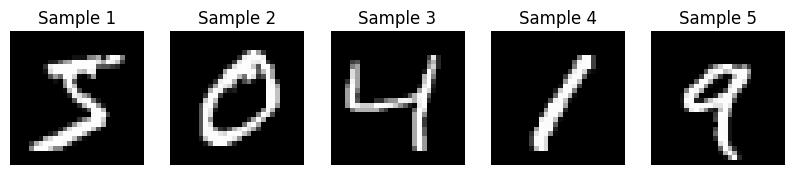

In [90]:


# Plot the sample images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i].reshape(img_height, img_width), cmap='gray')
    plt.title('Sample {}'.format(i+1))
    plt.axis('off')
plt.show()

In [91]:
input_shape

(28, 28, 1)

In [92]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((x_train))
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [93]:
60000/128

468.75

In [94]:
len(training_dataset)

469

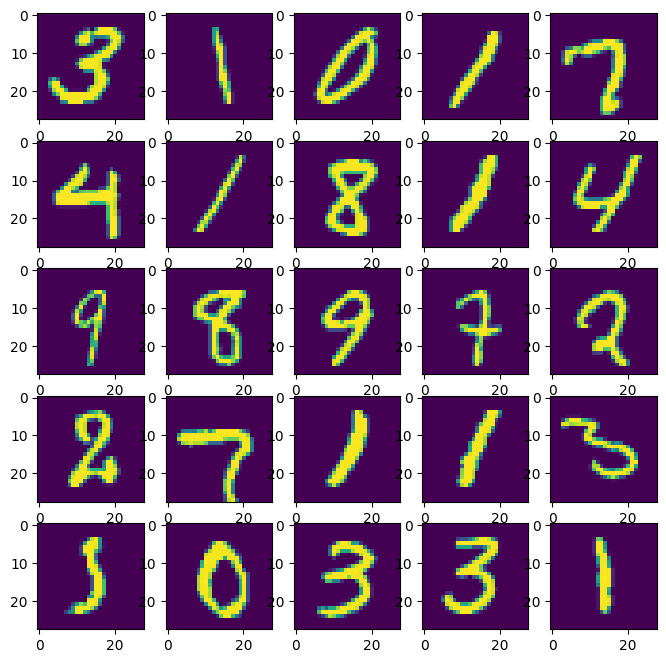

In [95]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (8,8))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [96]:
# build the model

latent_dim = 512

In [97]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers  import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K

In [98]:
K.clear_session()

In [99]:
encoder_input = Input(shape=(28,28,1))
x = Conv2D(32,kernel_size = 5, activation= LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64, 128, 256, 512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation=LeakyReLU(0.02), strides=2, padding='same')(x)
    x = BatchNormalization()(x)

In [100]:
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
encoder_output = BatchNormalization()(x)

In [101]:
# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

In [102]:
epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])


In [103]:
encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           832       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           51264     ['batch_normalization[0]

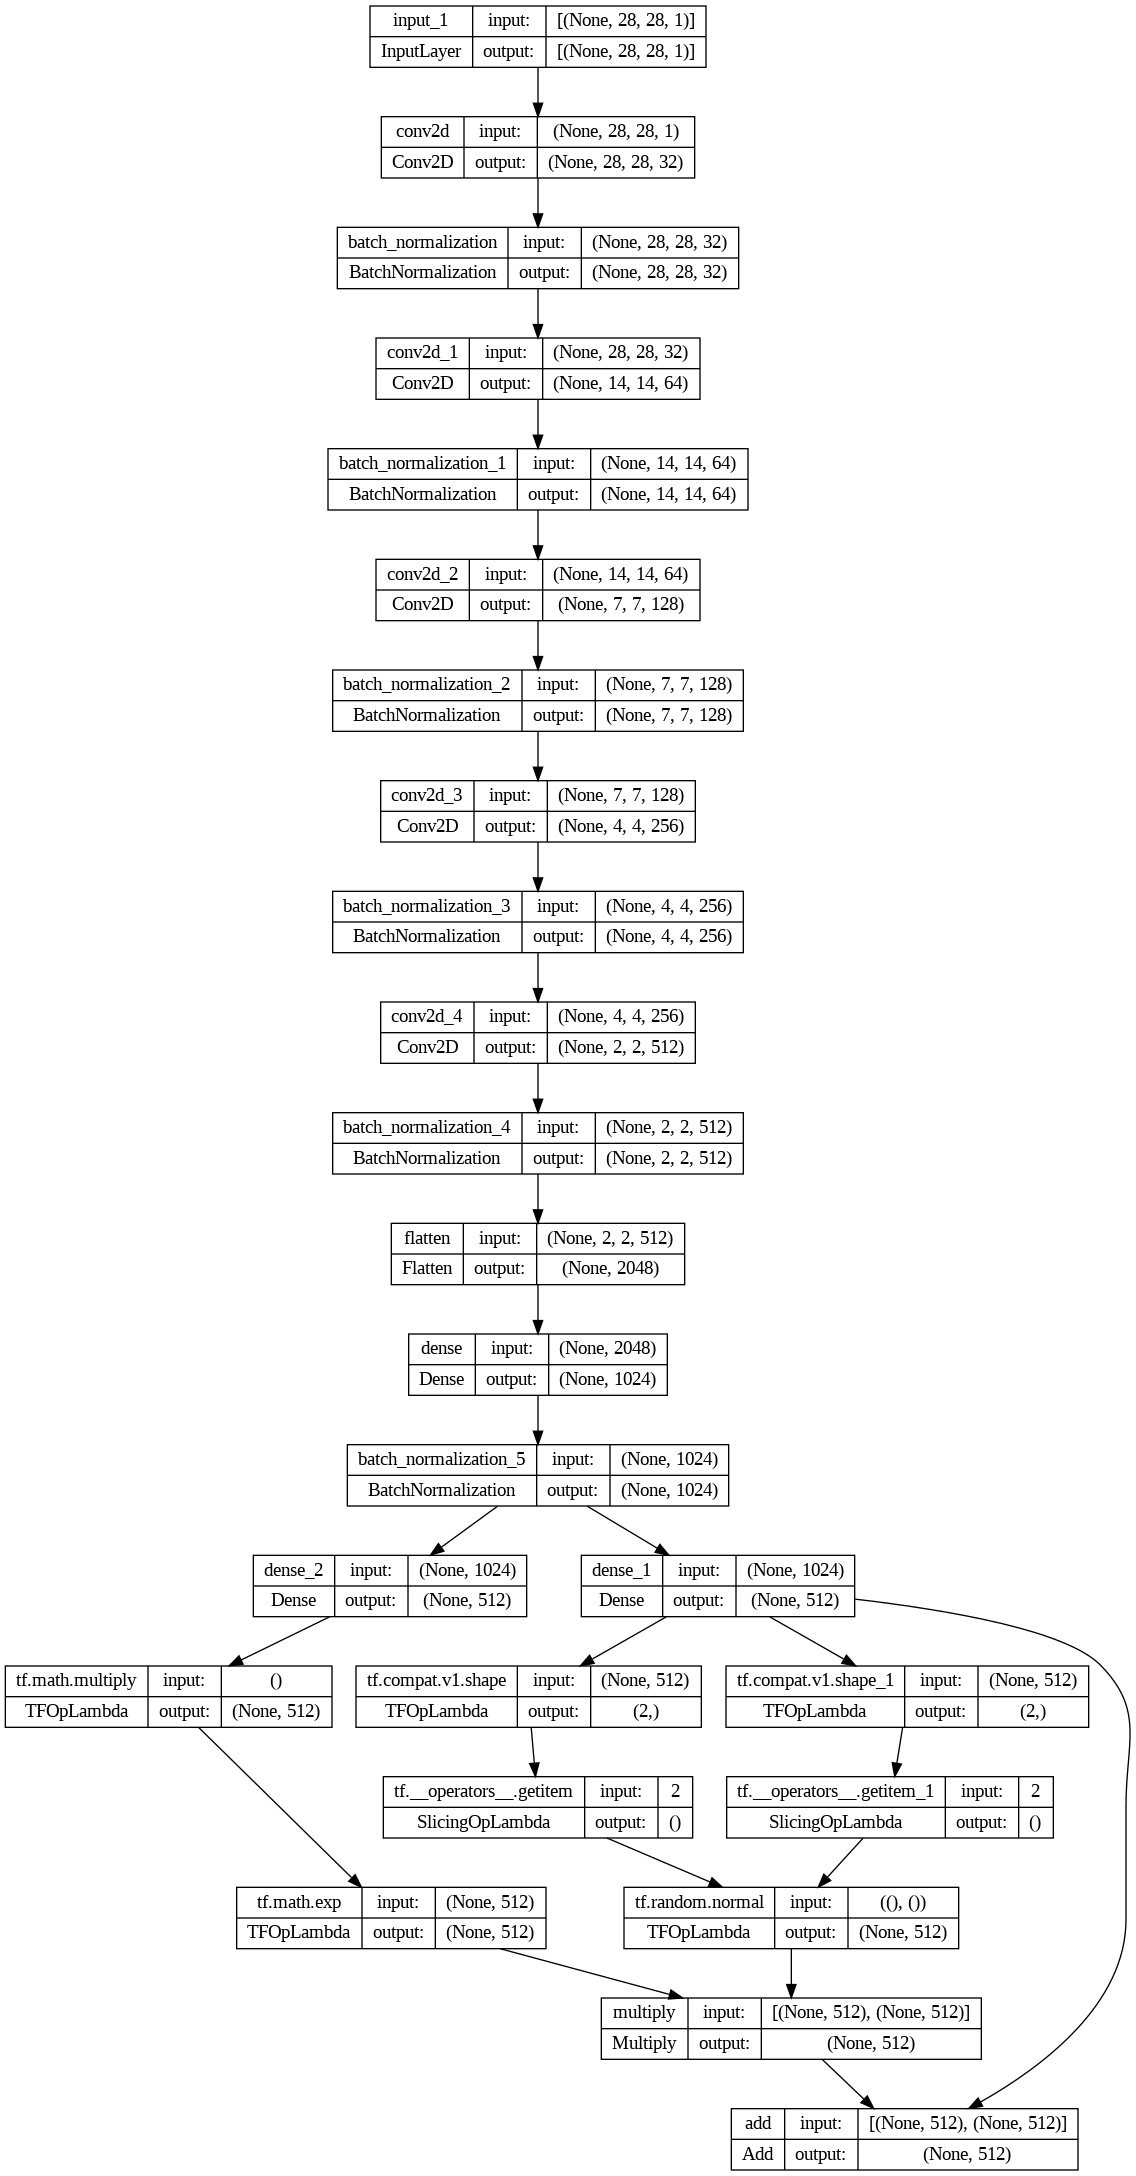

In [114]:
from tensorflow.keras.utils import plot_model

# Visualize the architecture of the encoder
plot_model(encoder, to_file='encoder_architecture.png', show_shapes=True, show_layer_names=True)


In [104]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = 'relu', input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(6272, activation = 'relu'))
decoder.add(Reshape((7,7,128)))


decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(1, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 6272)              6428800   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 64)        2

In [105]:
# make loss function
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (28*28)) * kl_loss(mu, log_var)

In [ ]:
# I tried with these loss functions, but encountered errors, so I proceeded with the previous one. Did not completely understand:
#One particularly devious issue comes up when using Keras losses like BinaryCrossentropy or MeanSquaredError. By default, this will compute a per-pixel loss and then average over all pixels. However, in this case we should sum over pixels since:
#We make the assumption that pixels are independent.
#With independence, the image probability becomes the product of pixel probabilities.
#Since we use log probabilities, this becomes the sum of log probabilities.

beta = 1.5

# Reconstruction loss function (Negative Log Likelihood)
def reconstruction_loss(y_true, y_pred):
    # Assuming pixel-wise independence, use Binary Crossentropy
    pixelwise_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=[1, 2,3])
    return tf.reduce_mean(pixelwise_loss)

def kl_loss(mu, log_var, beta):
    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
    return beta * tf.reduce_mean(kl_loss)

# VAE loss function for beta-VAE
def vae_loss(y_true, y_pred, mu, log_var, beta):
    return reconstruction_loss(y_true, y_pred) + kl_loss(mu, log_var, beta)


In [106]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                7509632   ['input_1[0][0]']             
                              (None, 512),                                                        
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 28, 28, 1)            7215493   ['encoder[0][2]']             
                                                                                                

In [107]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (7,7))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "/content/drive/MyDrive/LGM/output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [108]:
from keras.optimizers import Adam

random_vector = tf.random.normal(shape=(25, latent_dim))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 50  # Limit training to 20 epochs
print_step = 400  # Print progress every 100 steps

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape=[-1])
            y_pred = tf.reshape(reconstructed, shape=[-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(model.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % print_step == 0:
                save_images(decoder, epoch, step, random_vector)
                print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

            if step >= len(training_dataset):
                break

    if epoch >= epochs:
        break


1/1 [==============================] - 0s 226ms/step
Epoch:  1
1/1 [==============================] - 0s 17ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.22977479 - KL loss: 8.793095e-06
1/1 [==============================] - 0s 17ms/step
Epoch: 1 - Step: 400 - MSE loss: 0.028836483 - KL loss: 0.24775366
Epoch:  2
1/1 [==============================] - 0s 20ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.022142474 - KL loss: 0.28724664
1/1 [==============================] - 0s 19ms/step
Epoch: 2 - Step: 400 - MSE loss: 0.014987033 - KL loss: 0.3267511
Epoch:  3
1/1 [==============================] - 0s 19ms/step
Epoch: 3 - Step: 0 - MSE loss: 0.014132635 - KL loss: 0.31567723
1/1 [==============================] - 0s 33ms/step
Epoch: 3 - Step: 400 - MSE loss: 0.011561659 - KL loss: 0.35499227
Epoch:  4
1/1 [==============================] - 0s 17ms/step
Epoch: 4 - Step: 0 - MSE loss: 0.011086992 - KL loss: 0.3437853
1/1 [==============================] - 0s 17ms/step
Epoch: 4 - Step: 400 - MSE loss

In [109]:

import cv2
import os
import imageio

In [110]:
import glob# Define the name for the output GIF
anim_file = 'cvae.gif'

# Initialize the GIF writer
with imageio.get_writer(anim_file, mode='I') as writer:
    # Get a list of image filenames matching the pattern
    filenames = glob.glob('/content/drive/MyDrive/LGM/output/Epoch_*_step_*.jpg')
    # Sort the filenames (optional)
    filenames = sorted(filenames)

    # Append each image to the GIF
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Print a message indicating the GIF creation is completed
print(f"GIF created successfully: {anim_file}")

<ipython-input-110-cc1626cc4c87>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF created successfully: cvae.gif


In [111]:
pip install tensorflow-docs


In [112]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
